In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.stats import sem
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
figurepath = Path.cwd().parent.parent / "figures/PL"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1),aspect_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [7]:
import math
def round_half_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n*multiplier - 0.5) / multiplier

In [8]:
int(round_half_down(1.51))

2

In [9]:
def modified_disorder_mean(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def modified_disorder_std(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    arr_mean = modified_disorder_mean(arr,distance_matrix,bin_length)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff = int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += (arr[:,j,shot]-arr_mean[:,j_eff])**2
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = np.sqrt(new_arr[:,bin]/(counts[bin]*(counts[bin]-1)))
    return new_arr

def count_bins_total(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff] += 1
    return counts

In [10]:
def modified_disorder_mean_var(arr,distance_matrix,spacing):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    #n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    n_bins = N//2+1
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                #j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def modified_disorder_std_var(arr,distance_matrix,spacing):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    #n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    n_bins = N//2+1
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    arr_mean = modified_disorder_mean(arr,distance_matrix,spacing)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                #j_eff= int(distance_matrix[0,j,shot]/bin_length)+
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            #j_eff = int(distance_matrix[0,j,shot]/bin_length)
            new_arr[:,j_eff] += (arr[:,j,shot]-arr_mean[:,j_eff])**2
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = np.sqrt(new_arr[:,bin]/(counts[bin]*(counts[bin]-1)))
    return new_arr

def count_bins_total_var(distance_matrix,spacing):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
#    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    n_bins = N//2+1
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                #j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff] += 1
    return counts

In [11]:
def get_jeff(distance_matrix,bin_length):
    N = distance_matrix.shape[1]
    SHOTS = distance_matrix.shape[2]
    new_arr = np.zeros((N,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
                if j_eff == 0:
                    j_eff = 1
            new_arr[j,shot] = j_eff
    return new_arr

def get_jeff_var(distance_matrix,spacing):
    N = distance_matrix.shape[1]
    SHOTS = distance_matrix.shape[2]
    new_arr = np.zeros((N,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            new_arr[j,shot] = j_eff
    return new_arr

In [12]:
def bin_data(arr,distance_matrix,bin_length):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    new_arr = np.zeros((arr.shape[0],n_bins,SHOTS))
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            new_arr[:,j_eff,shot] += arr[:,j,shot]
            counts[j_eff,shot] += 1
        for bin in range(0,n_bins):
            if counts[bin,shot] != 0:
                new_arr[:,bin,shot] = new_arr[:,bin,shot]/counts[bin,shot]
    return new_arr

def count_bins(distance_matrix,bin_length):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff,shot] += 1
    return counts

In [13]:
def bin_data_var(arr,distance_matrix,spacing):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    #n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    n_bins = N//2+1
    new_arr = np.zeros((arr.shape[0],n_bins,SHOTS))
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                #j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            new_arr[:,j_eff,shot] += arr[:,j,shot]
            counts[j_eff,shot] += 1
        for bin in range(0,n_bins):
            if counts[bin,shot] != 0:
                new_arr[:,bin,shot] = new_arr[:,bin,shot]/counts[bin,shot]
    return new_arr

def count_bins_var(distance_matrix,spacing):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    #n_bins = int(np.max(distance_matrix[0,:,:])/bin_length)+1+1 #Bins {0},(0,l),[l,2l),...
    n_bins = N//2+1
    counts = np.zeros((n_bins,SHOTS))
    for shot in range(0,SHOTS):
        for j in range(0,N):
            if j == 0:
                j_eff = 0
            else:
                #j_eff= int(distance_matrix[0,j,shot]/bin_length)+1
                j_eff = int(round_half_down(distance_matrix[0,j,shot]/spacing))
                if j_eff == 0:
                    j_eff = 1
            #j_eff= int(distance_matrix[0,j,shot]/bin_length)
            counts[j_eff,shot] += 1
    return counts

In [14]:
jobids = []
params = []
data = []
positiondesc = []
positions = []
distance_matrices = []
folders = [datapath/"d={}".format(i) for i in [1.99,1.8,1.5,1.2,0.9,0.6]]
filenames = ["combined_file_d{}.jld2".format(i) for i in [1.99,1.8,1.5,1.2,0.9,0.6]]

for i in range(len(folders)):
    with h5py.File(folders[i]/filenames[i],"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]] for l in range(len(f["data"]))]))
        params.append(f["params"][()])
        positiondesc.append([f[f["positiondata"][l]][()][0] for l in range(len(f["positiondata"]))])
        ref_desc = [f[f["positiondata"][l]][()][1] for l in range(len(f["positiondata"]))]
        positions.append(np.array([f[ref_desc[l]][()] for l in range(len(f["positiondata"]))]))
        ref_desc = [f[f["positiondata"][l]][()][2] for l in range(len(f["positiondata"]))]
        distance_matrices.append(np.array([f[ref_desc[l]][()] for l in range(len(f["positiondata"]))]))

for  i in range(0,len(filenames)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
    positions[i] = np.swapaxes(np.concatenate(positions[i],axis=0),0,1)
    distance_matrices[i] = np.swapaxes(np.concatenate(distance_matrices[i],axis=0),0,2)

In [15]:
N = 13
SHOTS = [data[i].shape[2] for i in range(len(filenames))]
T = 10 ** np.linspace(-3,10,250)
rhos = [1.99,1.8,1.5,1.2,0.9,0.6]

In [16]:
for i in range(len(folders)):
    print(data[i].shape[2],"\n")

100 

500 

500 

475 

500 

450 



# No binning

In [17]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize_new(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(1,N//2+1):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,-j])
    symarr[:,0] = arr[:,0]
    return symarr

In [18]:
res = [disorder_mean(data[i]) for i in range(len(filenames))]
res_sem = [disorder_sem(data[i]) for i in range(len(filenames))]
red = list(map(symmetrize_new,res))
red_sem = list(map(symmetrize_new,res_sem))

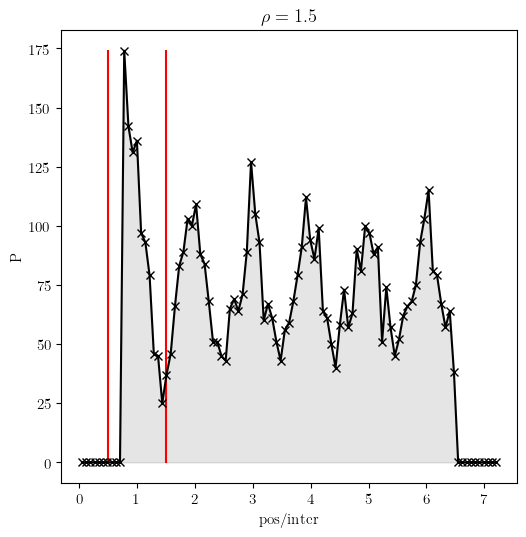

In [19]:
ds = 2
Nbins = 100
s = 2/positiondesc[ds][0][-1]
bin_edges = np.linspace(0.01,distance_matrices[ds][0,:,:].max()+1,Nbins)
l = bin_edges[1]-bin_edges[0]
p,x = np.histogram(distance_matrices[ds][0,:,:],bins=bin_edges,density=False)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
x = x/s
plt.plot([(s-s/2)/s,(s-s/2)/s],[0,p.max()],c="red")
plt.plot([(s+s/2)/s,(s+s/2)/s],[0,p.max()],c="red")
plt.plot(x,p,color="black",marker="x")
plt.fill_between(x,np.zeros(Nbins-1),p,alpha=0.1,color="black")
plt.title(r"$\rho = {}$".format(positiondesc[ds][0][-1]))
plt.ylabel("P")
plt.xlabel("pos/inter")
#plt.xlim(-0.1,bin_edges.max())
plt.xticks(np.arange(0,bin_edges.max()/s))
plt.show()

In [20]:
for ds in range(len(folders)):
    print(distance_matrices[ds][0,1:,:].max()/(2/positiondesc[ds][0][-1]))

6.012440240407247
6.2937394156713244
6.494804166317698
6.499017958457665
6.4982050853022795
6.49860769732796


In [21]:
spacings = [2/positiondesc[ds][0][-1] for ds in range(len(folders))]
res_m = list(map(lambda arr,distance_matrix,l: modified_disorder_mean(arr,distance_matrix,l), data, distance_matrices, spacings))
res_err = list(map(lambda arr,distance_matrix,l: modified_disorder_std(arr,distance_matrix,l), data, distance_matrices, spacings))
counts = list(map(lambda distance_matrix,l: count_bins(distance_matrix,l),distance_matrices, spacings))
counts_tot = list(map(lambda distance_matrix,l: count_bins_total(distance_matrix,l),distance_matrices, spacings))

In [22]:
spacings_var = [2/positiondesc[ds][0][-1] for ds in range(len(folders))]
res_m_var = list(map(lambda arr,distance_matrix,l: modified_disorder_mean_var(arr,distance_matrix,l), data, distance_matrices, spacings_var))
res_err_var = list(map(lambda arr,distance_matrix,l: modified_disorder_std_var(arr,distance_matrix,l), data, distance_matrices, spacings_var))
counts_var = list(map(lambda distance_matrix,l: count_bins_var(distance_matrix,l),distance_matrices, spacings_var))
counts_tot_var = list(map(lambda distance_matrix,l: count_bins_total_var(distance_matrix,l),distance_matrices, spacings_var))

In [23]:
#C6 = 400/(2*np.pi) * 1e9 #Hz(μm)^6
#r = 7 #μm

In [24]:
J[:,:,0].diagonal(1)

NameError: name 'J' is not defined

In [25]:
Jm = np.zeros(len(folders))
for ds in range(len(folders)):
    #J = C6*0.25*np.power(r*distance_matrices[ds],-6)[:,:,:]
    J = np.power(distance_matrices[ds],-6)[:,:,:]
    Jm[ds] = np.mean([np.median(J[:,:,i].diagonal(1)) for i in range(0,SHOTS[ds])])
    #print(np.std([np.median(J[:,:,i].diagonal(1)) for i in range(0,50)])/np.sqrt(50))

/tmp/ipykernel_159883/3503803954.py:4: RuntimeWarning: divide by zero encountered in power
  J = np.power(distance_matrices[ds],-6)[:,:,:]


In [26]:
np.median(dist)

NameError: name 'dist' is not defined

In [27]:
np.mean

<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>

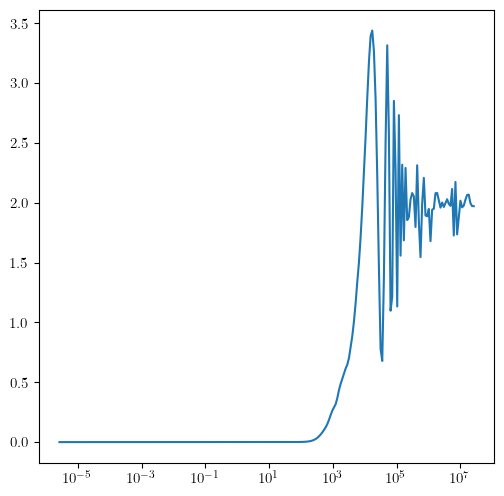

In [28]:
plt.semilogx(Jm[5]*T,data[5][:,6,10])

In [29]:
ds = 5
jeffs_var = get_jeff_var(distance_matrices[ds],spacings[ds])


In [30]:
c = np.zeros(N//2+1)
for j in range(0,N//2+1):
    for s in range(0,450):
        if 2 == jeffs_var[j,s]:
            c[j] += 1
c        

array([  0., 109., 227.,  79.,   3.,   0.,   0.])

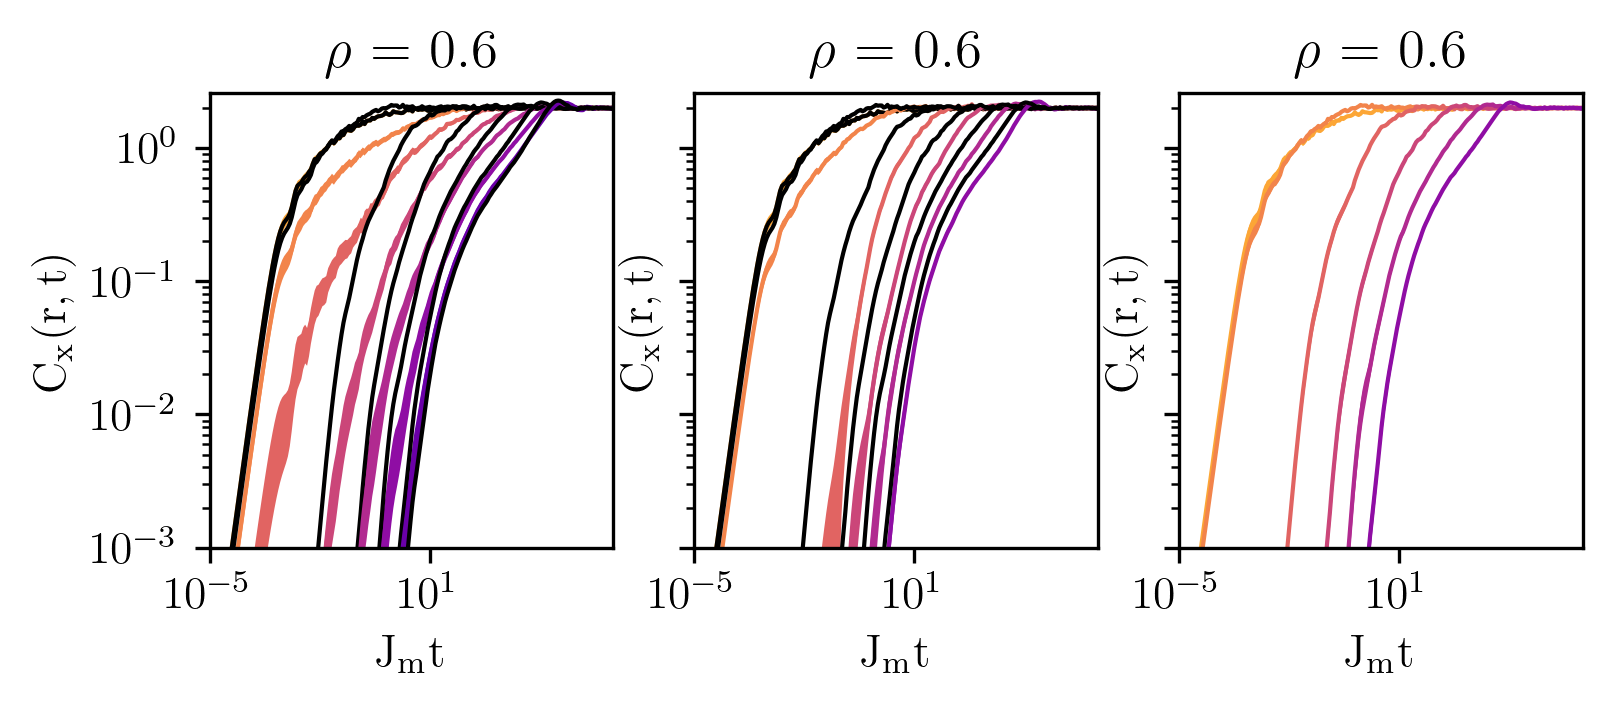

In [33]:
ds = 5

fig, axs = plt.subplots(1,3,figsize=set_size(subplots=(1,3)),dpi = 300,sharey=True)
axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0].plot(Jm[ds]*T,red[ds][:,j],label=r"$r_M$ = {}".format(j),lw=1)
    axs[0].plot(Jm[ds]*T,res_m[ds][:,j],label=r"$r_M$ = {}".format(j),lw=1,c="black")
    axs[0].fill_between(Jm[ds]*T, red[ds][:,j]-red_sem[ds][:,j], red[ds][:,j]+red_sem[ds][:,j])

axs[0].set_xlabel(r"$\mathrm{J_mt}$")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title(r"$\rho$ = {}".format(rhos[ds]))
axs[0].set_xlim(1e-5,1e6)
axs[0].set_ylim(1e-3,2.6)

axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,len(counts_var)):
    axs[1].plot(Jm[ds]*T,res_m_var[ds][:,j],label=r"$r_M$ = {}".format(j),lw=1)
    axs[1].plot(Jm[ds]*T,res_m[ds][:,j],label=r"$r_M$ = {}".format(j),lw=1,c="black")

    axs[1].fill_between(Jm[ds]*T, res_m_var[ds][:,j]-res_err_var[ds][:,j], res_m_var[ds][:,j]+res_err_var[ds][:,j])

axs[1].set_xlabel(r"$\mathrm{J_mt}$")
axs[1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[1].set_title(r"$\rho$ = {}".format(rhos[ds]))
axs[1].set_xlim(1e-5,1e6)
axs[1].set_ylim(1e-3,2.6)

axs[2].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2].set_xscale("log")
for j in range(0,len(counts)):
    axs[2].plot(Jm[ds]*T,res_m[ds][:,j],label=r"$r_M$ = {}".format(j),lw=1)
    axs[2].fill_between(Jm[ds]*T, res_m[ds][:,j]-res_err[ds][:,j], res_m[ds][:,j]+res_err[ds][:,j])

axs[2].set_xlabel(r"$\mathrm{J_mt}$")
axs[2].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[2].set_title(r"$\rho$ = {}".format(rhos[ds]))
axs[2].set_xlim(1e-5,1e6)
axs[2].set_ylim(1e-3,2.6)

axs[2].set_yscale("log")

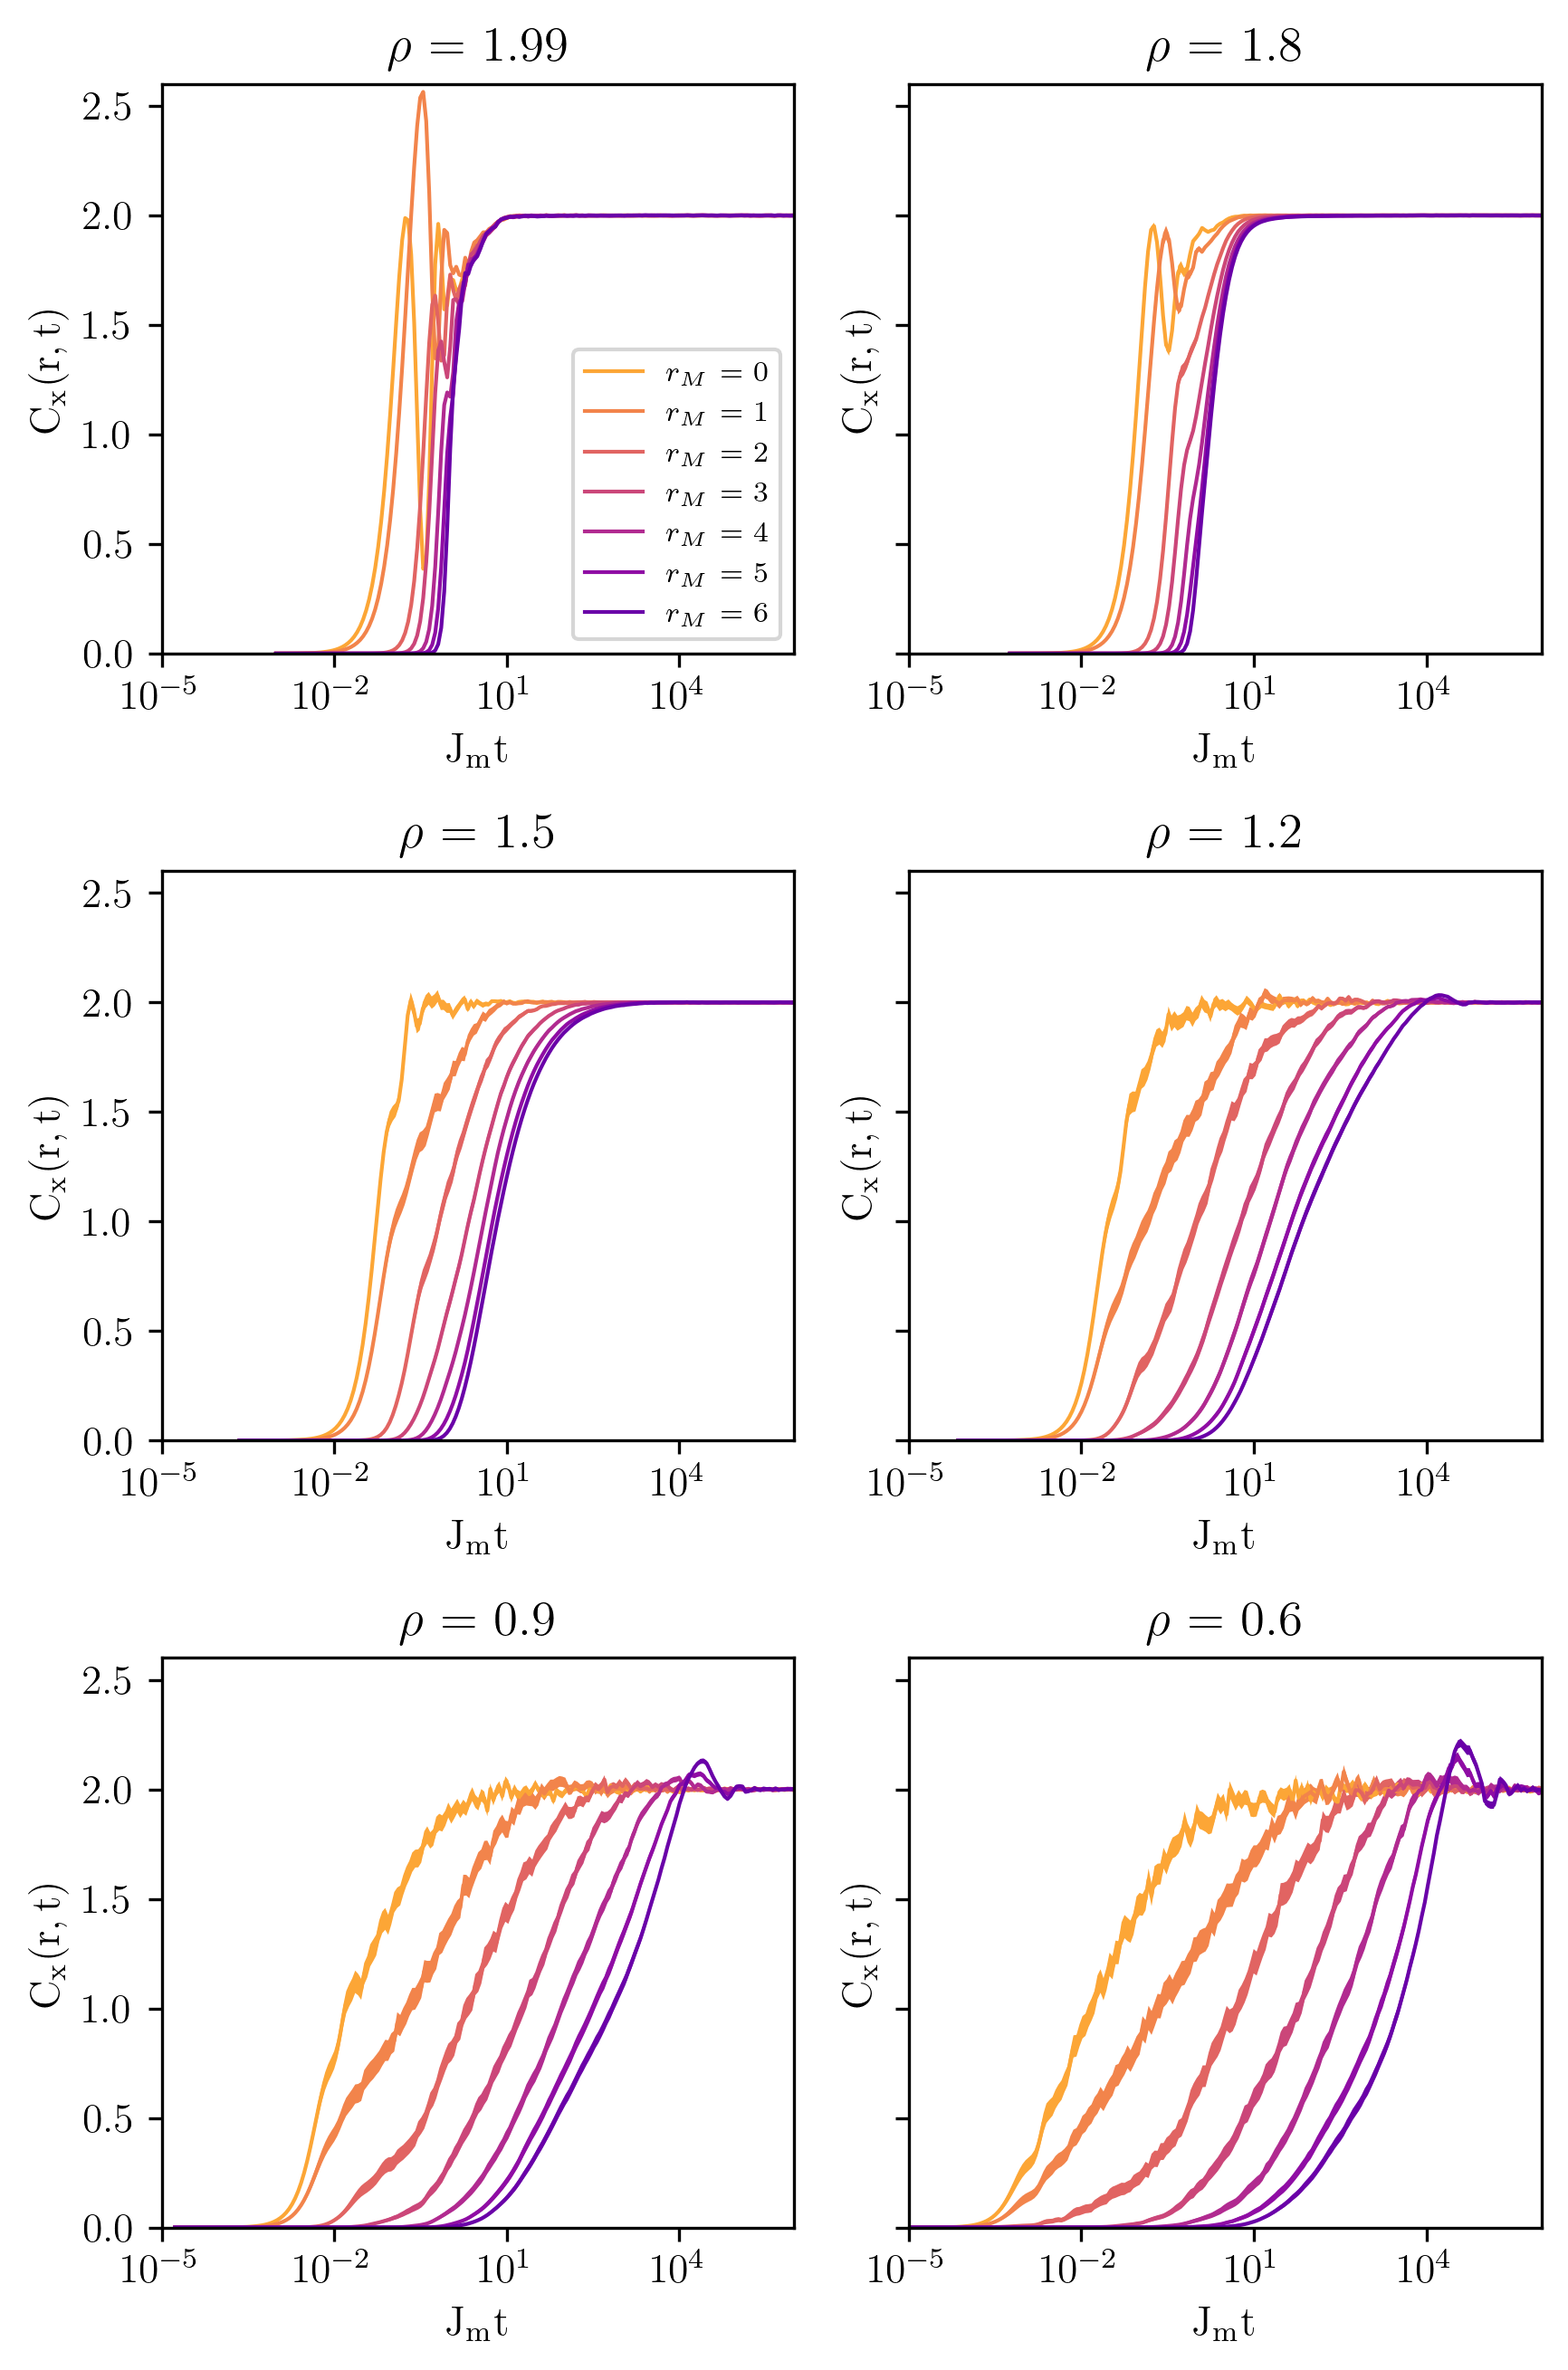

In [32]:
fig, axs = plt.subplots(3,2,figsize=set_size(subplots=(3,2)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+4 #11
cm = plt.get_cmap('plasma_r')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,0].plot(Jm[0]*T,red[0][:,j],label=r"$r_M$ = {}".format(j),lw=1)
    axs[0,0].fill_between(Jm[0]*T, red[0][:,j]-red_sem[0][:,j], red[0][:,j]+red_sem[0][:,j])


axs[0,0].legend(loc="lower right",fontsize = "x-small")
axs[0,0].set_xlabel(r"$\mathrm{J_mt}$")
axs[0,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0,0].set_title(r"$\rho$ = {}".format(rhos[0]))
axs[0,0].set_xlim(1e-5,1e6)
axs[0,0].set_ylim(0,2.6)

axs[0,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[0,1].plot(Jm[1]*T,red[1][:,j],label=r"$r_M$={}".format(j),lw=1)
    axs[0,1].fill_between(Jm[1]*T, red[1][:,j]-red_sem[1][:,j], red[1][:,j]+red_sem[1][:,j])

axs[0,1].set_xlabel(r"$\mathrm{J_mt}$")
axs[0,1].set_title(r"$\rho$ = {}".format(rhos[1]))
axs[0,1].set_xlim(1e-5,1e6)
axs[0,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")


axs[1,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,0].plot(Jm[2]*T,red[2][:,j],label=r"$r_M$={}".format(j),lw=1)
    axs[1,0].fill_between(Jm[2]*T, red[2][:,j]-red_sem[2][:,j], red[2][:,j]+red_sem[2][:,j])

axs[1,0].set_xlabel(r"$\mathrm{J_mt}$")
axs[1,0].set_title(r"$\rho$ = {}".format(rhos[2]))
axs[1,0].set_xlim(1e-5,1e6)
axs[1,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[1,0].set_ylim(0,2.6)

###########
## Lowest ##
###########

axs[1,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1,1].plot(Jm[3]*T,red[3][:,j],label=r"$r_M$={}".format(j),lw=1)
    axs[1,1].fill_between(Jm[3]*T, red[3][:,j]-red_sem[3][:,j], red[3][:,j]+red_sem[3][:,j])

axs[1,1].set_xlabel(r"$\mathrm{J_mt}$")
axs[1,1].set_title(r"$\rho$ = {}".format(rhos[3]))
axs[1,1].set_xlim(1e-5,1e6)
axs[1,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")

axs[2,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,0].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,0].plot(Jm[4]*T,red[4][:,j],label=r"$r_M$={}".format(j),lw=1)
    axs[2,0].fill_between(Jm[4]*T, red[4][:,j]-red_sem[4][:,j], red[4][:,j]+red_sem[4][:,j])

axs[2,0].set_xlabel(r"$\mathrm{J_mt}$")
axs[2,0].set_title(r"$\rho$ = {}".format(rhos[4]))
axs[2,0].set_xlim(1e-5,1e6)
axs[2,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[2,0].set_ylim(0,2.6)


axs[2,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[2,1].set_xscale("log")
for j in range(0,N//2+1):
    axs[2,1].plot(Jm[5]*T,red[5][:,j],label=r"$r_M$={}".format(j),lw=1)
    axs[2,1].fill_between(Jm[5]*T, red[5][:,j]-red_sem[5][:,j], red[5][:,j]+red_sem[5][:,j])

axs[2,1].set_xlabel(r"$\mathrm{J_mt}$")
axs[2,1].set_title(r"$\rho$ = {}".format(rhos[5]))
axs[2,1].set_xlim(1e-5,1e6)
axs[2,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")


plt.tight_layout()
#plt.subplots_adjust(wspace=0.05, hspace=0.5)
plt.savefig(figurepath/"gallery_pl_naive.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Binning & Quick Plots

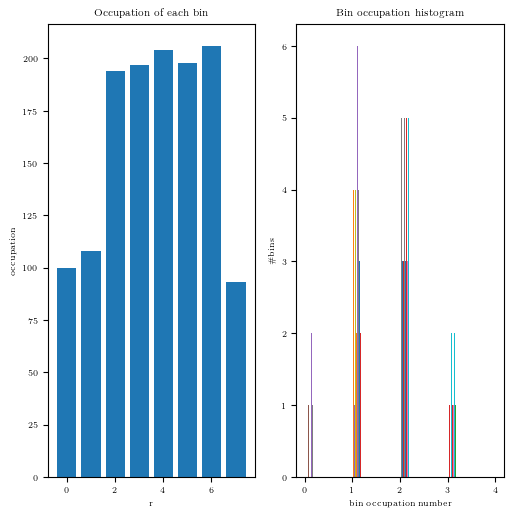

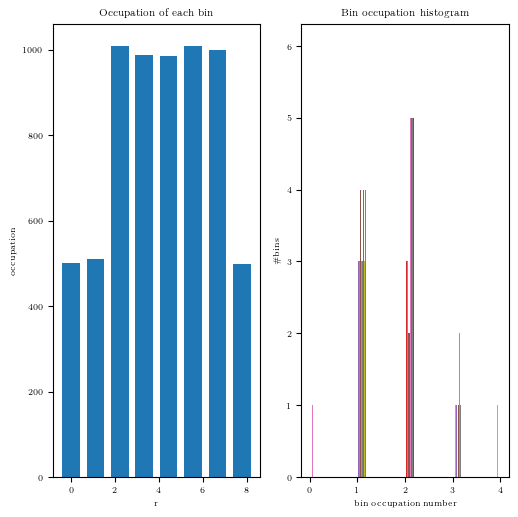

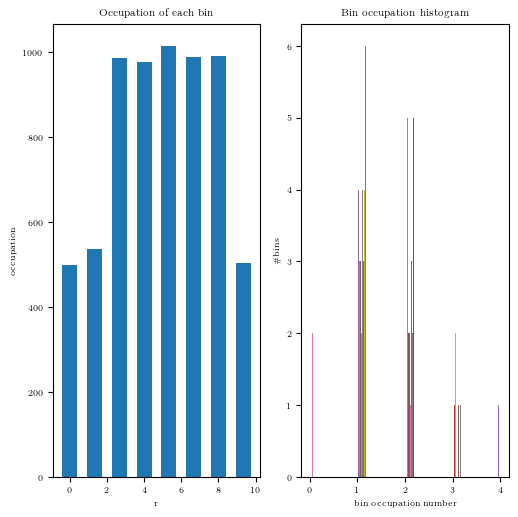

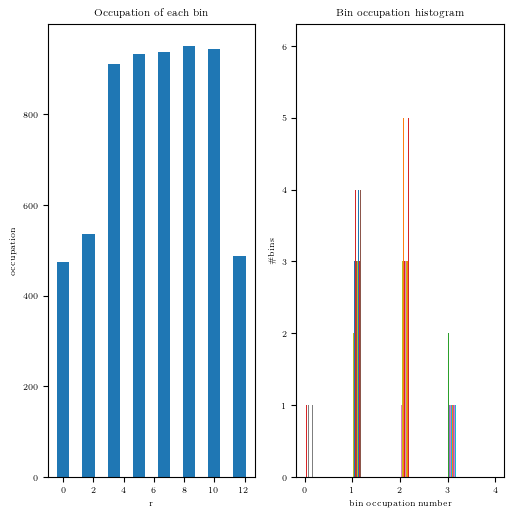

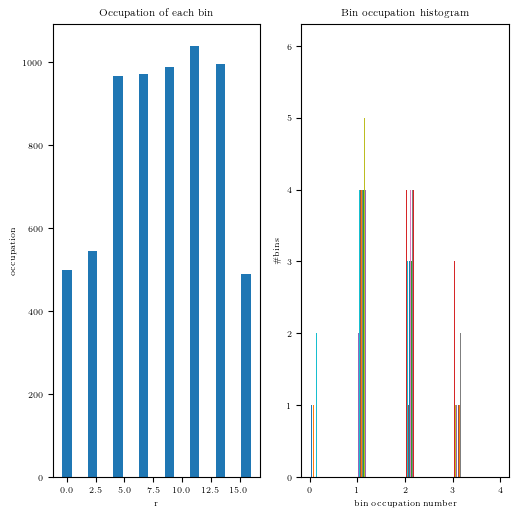

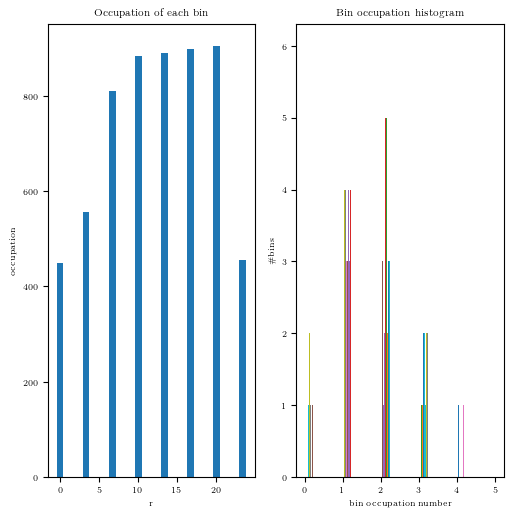

In [76]:
for ds in range(len(folders)):
    bins = [i*spacings[ds] for i in range(0,len(counts[ds]))]
    fig, axs = plt.subplots(1, 2)
    axs[1].hist(counts[ds],20)
    axs[1].set_title("Bin occupation histogram")
    axs[1].set_xlabel("bin occupation number")
    axs[1].set_ylabel(r"\#bins")

    axs[0].bar(bins,counts_tot[ds])
    axs[0].set_title("Occupation of each bin")
    axs[0].set_xlabel("r")
    axs[0].set_ylabel("occupation")
    #plt.suptitle(r"Binning disordered distances, bin length: {:.2f}; geometry:{}, $\rho=${}".format(ls[ds],positiondesc[ds][0][0].decode("UTF-8"),positiondesc[ds][0][-1]))
    plt.show()


# Fit to Disorder Average

In [34]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [35]:
def model(x,a,b):
    return a*x**b
def model2(x,a,b):
    return 2-a*np.exp(-b*x)
def model3(x,a,b,c):
    return 2-a*np.exp(-b*x**c)
def model4(x,a,b):
    return 2-a*x**b

In [36]:
ds = 3
popt = []
perr = []
tfitmax = [180,180,180,180,180,180,200]
tfitmin = [45,45,65,80,80,80,81]
for j in range(0,len(counts_var[ds])):
    poptj, pcovj = curve_fit(model3,T[tfitmin[j]:tfitmax[j]],res_m_var[ds][tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [37]:
popt

[array([14.10983143,  3.30436912,  0.24600659]),
 array([5.53631359, 1.68309418, 0.2420042 ]),
 array([2.8432974 , 0.31769321, 0.43324963]),
 array([3.04521683, 0.21119692, 0.36529129]),
 array([2.84327241, 0.1456568 , 0.34171759]),
 array([2.7215617 , 0.11734305, 0.32133746]),
 array([2.67268442, 0.10441653, 0.3109289 ])]

In [38]:
ds = -1
popt2 = []
perr2 = []
tfitmax2 = [180,180,145,160,180,190,200]
tfitmin2 = [60,60,100,120,120,130,140]
for j in range(2,len(counts_var[ds])):
    poptj, pcovj = curve_fit(model,T[tfitmin2[j]:tfitmax2[j]],res_m_var[ds][tfitmin2[j]:tfitmax2[j],j])
    popt2.append(poptj)
    perr2.append(np.sqrt(np.diag(pcovj)))

In [39]:
popt2

[array([0.05332319, 0.36045123]),
 array([0.01339932, 0.41380607]),
 array([0.00996787, 0.37654404]),
 array([0.00411473, 0.40359113]),
 array([0.00494382, 0.36866896])]

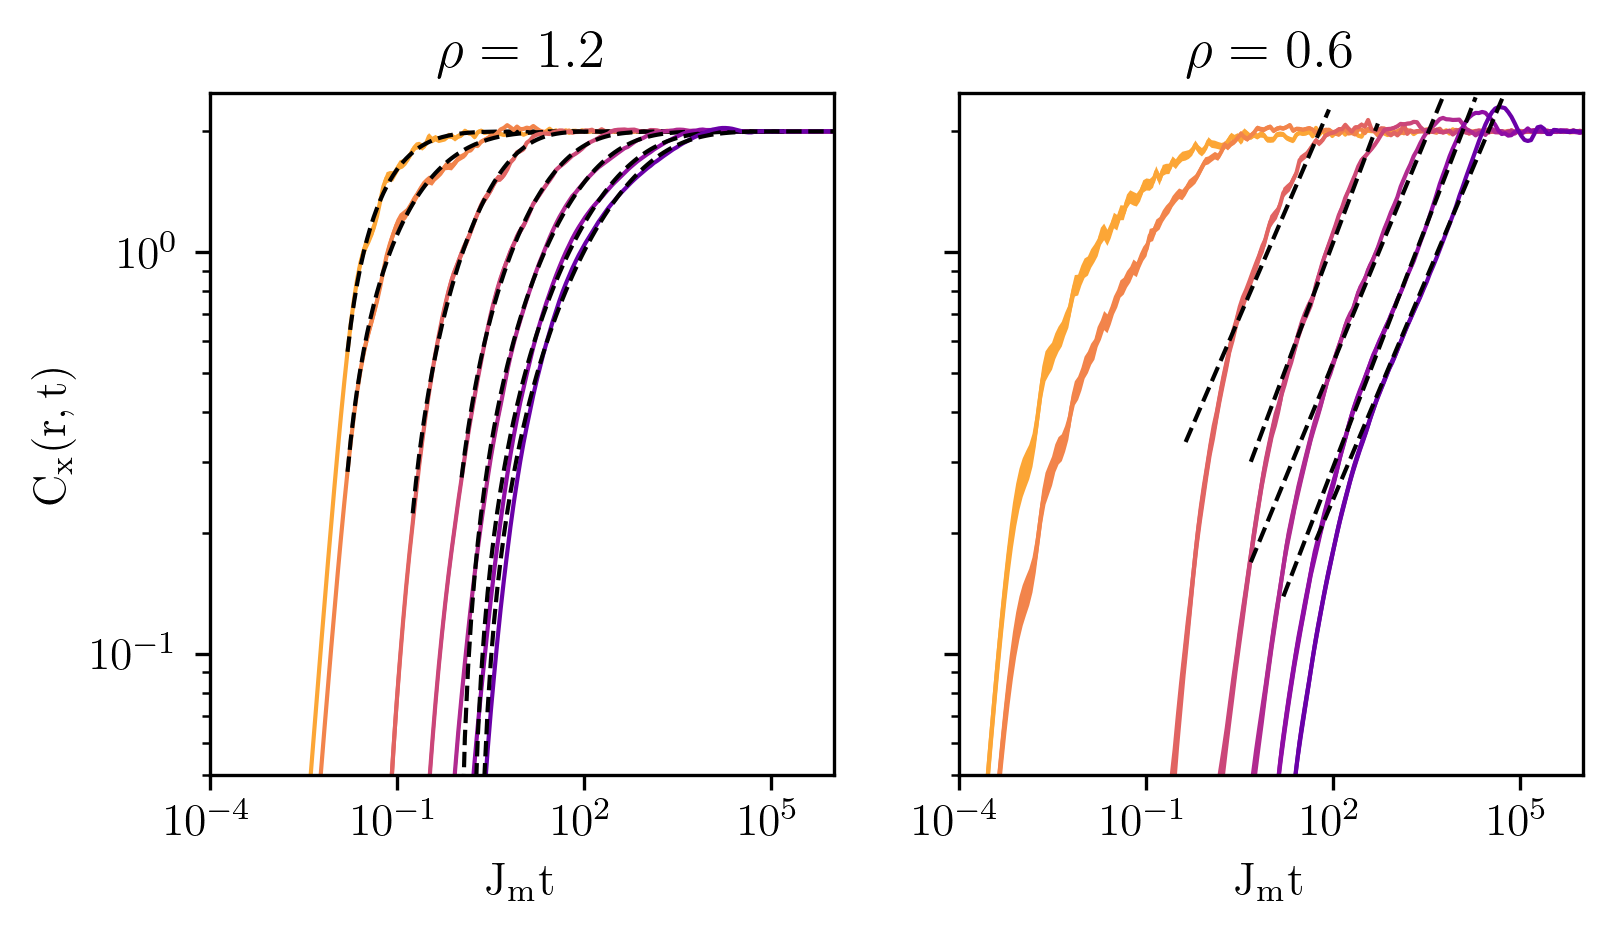

In [40]:
fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

NUM_COLORS = 13//2+4 #11
cm = plt.get_cmap('plasma_r')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

ds = 3

axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[0].set_xscale("log")
for j in range(0,len(counts_var[ds])):
    axs[0].plot(Jm[ds]*T,res_m_var[ds][:,j],lw=1)
    if j>=0:
        axs[0].plot(Jm[ds]*T[tfitmin[j]:tfitmax[j]],model3(T[tfitmin[j]:tfitmax[j]],*popt[j]),c="black",ls="dashed",lw=1)
    axs[0].fill_between(Jm[ds]*T, res_m_var[ds][:,j]-res_err_var[ds][:,j], res_m_var[ds][:,j]+res_err_var[ds][:,j])


axs[0].set_xlabel(r"$\mathrm{J_mt}$")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title(r"$\rho = {}$".format(rhos[ds]))
axs[0].set_xlim(1e-4,1e6)
axs[0].set_ylim(5e-2,2.5)
axs[0].set_yscale("log")


ds = -1
axs[1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
axs[1].set_xscale("log")
for j in range(0,N//2+1):
    axs[1].plot(Jm[ds]*T,res_m_var[ds][:,j],lw=1)
    if j>=2:
        axs[1].plot(Jm[ds]*T[tfitmin2[j]:tfitmax2[j]],model(T[tfitmin2[j]:tfitmax2[j]],*popt2[j-2]),c="black",ls="dashed",lw=1)
    axs[1].fill_between(Jm[ds]*T, res_m_var[ds][:,j]-res_err_var[ds][:,j], res_m_var[ds][:,j]+res_err_var[ds][:,j])


axs[1].set_xlabel(r"$\mathrm{J_mt}$")
axs[1].set_title(r"$\rho = {}$".format(rhos[ds]))
axs[1].set_xlim(1e-4,1e6)
axs[1].set_ylim(5e-2,2.5)
axs[1].set_yscale("log")



plt.savefig(figurepath/"disorder_fits_pl_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Coarse Comparison

In [41]:
Jm.max()*T.min()/1e7

9.73633604486712e-11

In [42]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 6,                   # Set font size to 11pt
    'axes.labelsize': 6,               # -> axis labels
    'legend.fontsize': 5,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [43]:
[len(counts[i]) for i in range(len(counts_var))]

[8, 8, 8, 8, 8, 8]

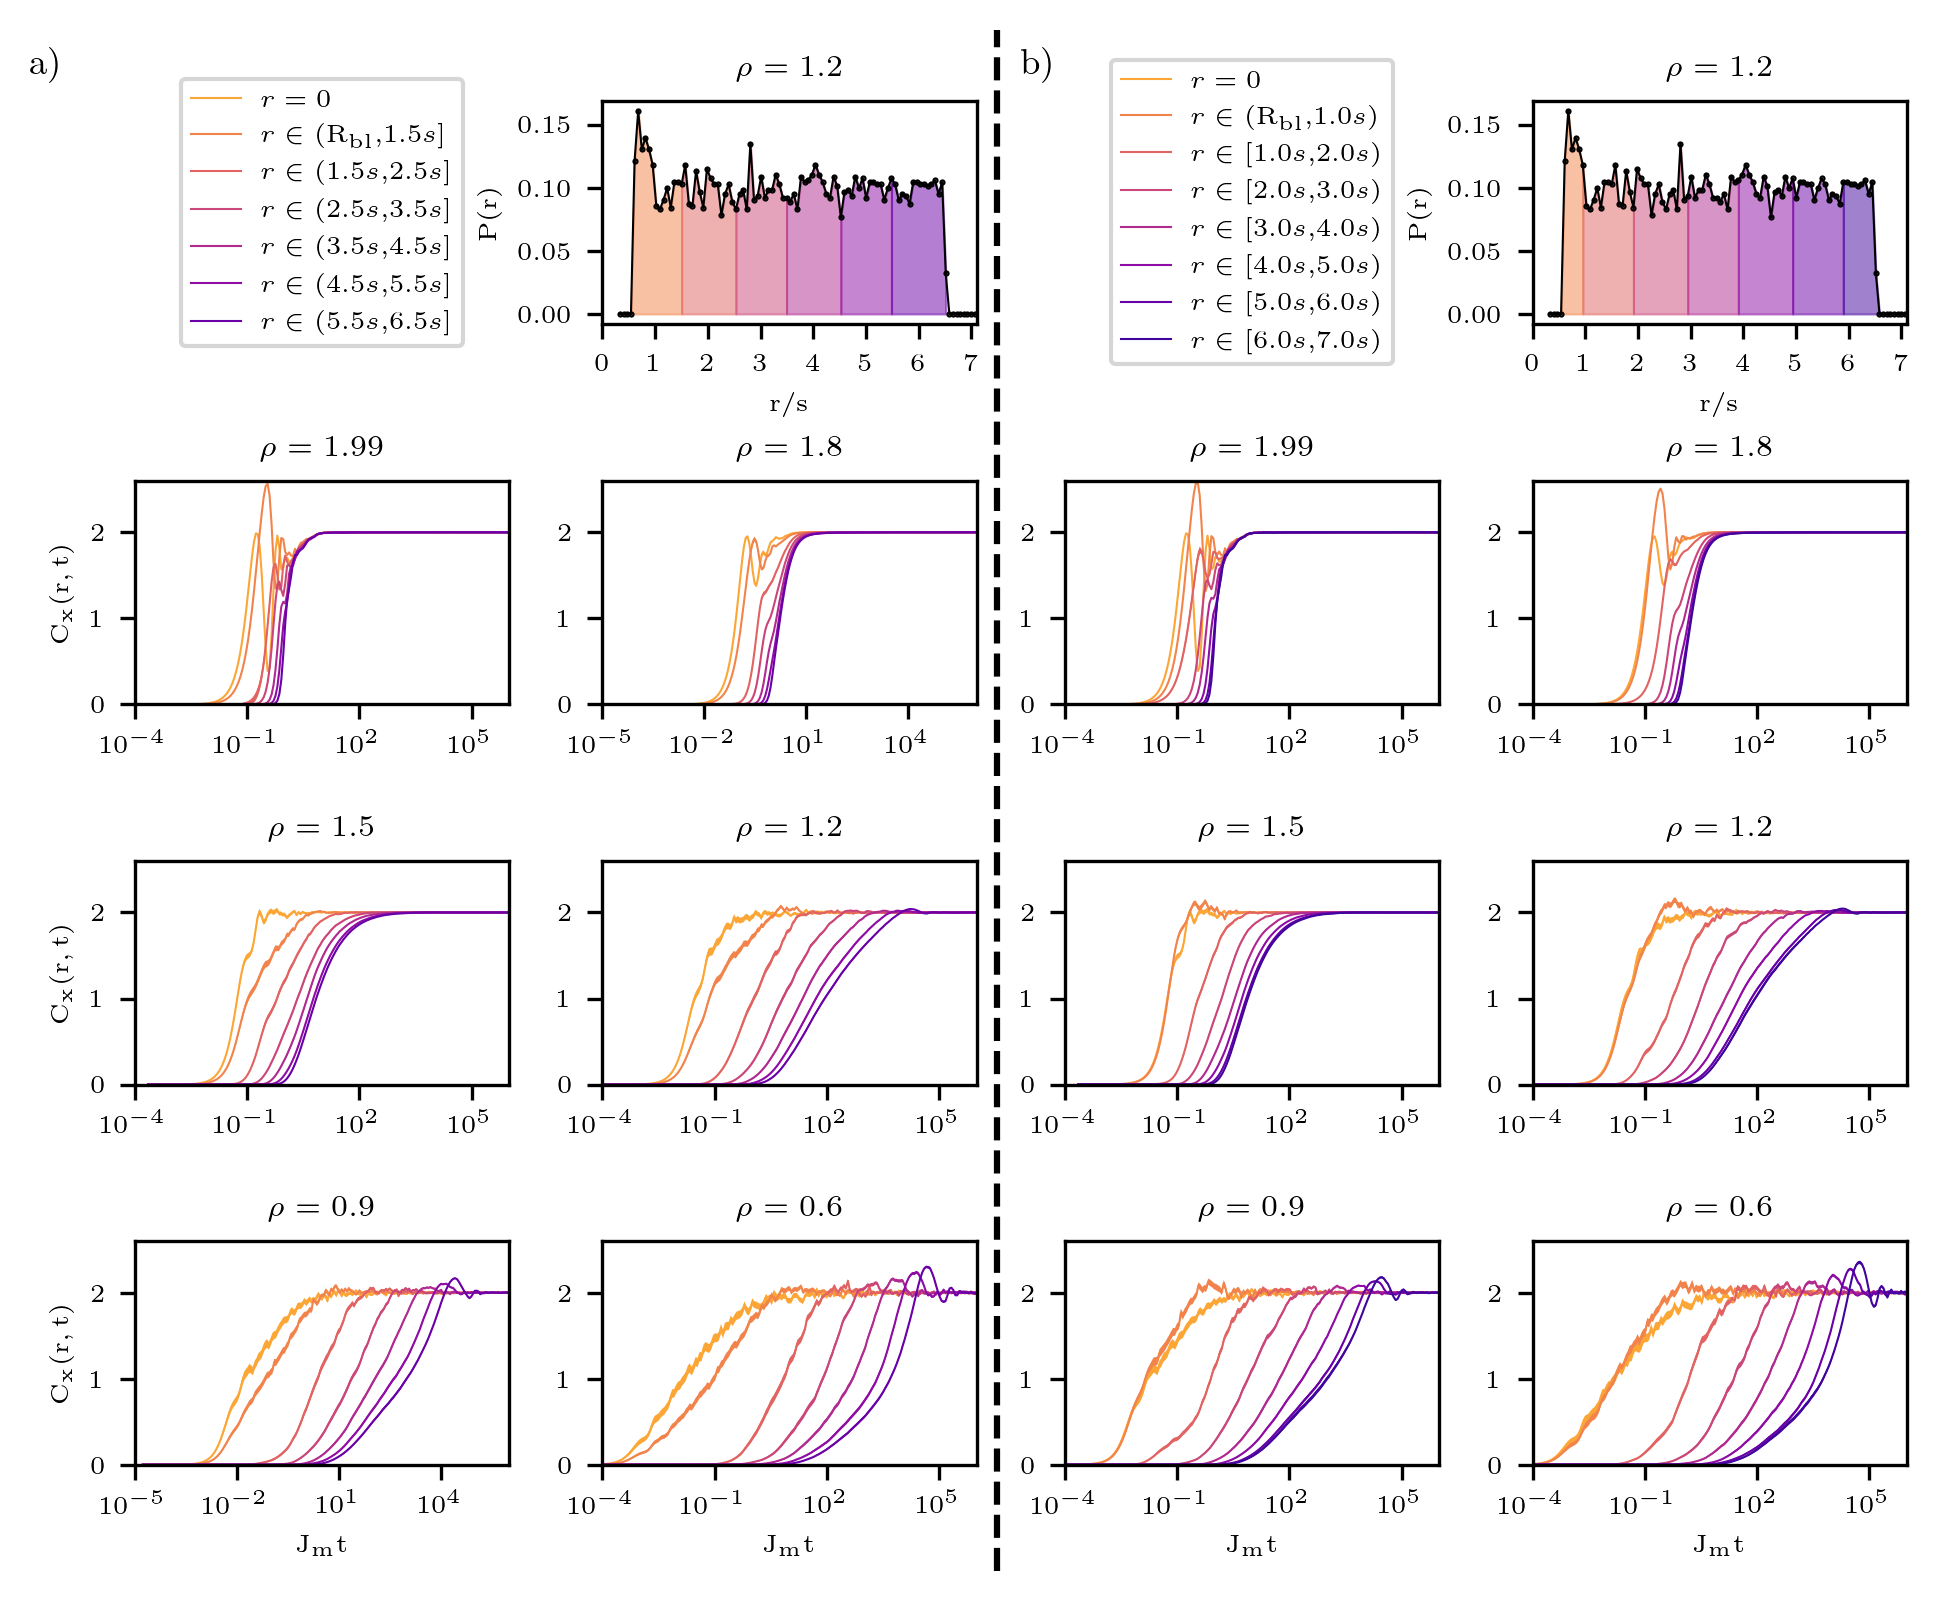

In [44]:
fig = plt.figure(figsize = set_size(subplots=(4,4)),dpi = 300)

gs1 = gridspec.GridSpec(4, 2,figure=fig)
gs1.update(left=0.0, right = 0.475, wspace = 0.25, hspace=0.7)
gs2 = gridspec.GridSpec(4, 2,figure=fig)
gs2.update(left=0.525, right = 1.0, wspace = 0.25, hspace=0.7)

axtl1 = plt.subplot(gs1[0, 0])
axtl2 = plt.subplot(gs1[0, 1])
axtr1 = plt.subplot(gs2[0, 0])
axtr2 = plt.subplot(gs2[0, 1])

axtl1.spines["top"].set_visible(False)
axtl1.spines["left"].set_visible(False)
axtl1.spines["bottom"].set_visible(False)
axtl1.spines["right"].set_visible(False)
axtl1.set_xticks([])
axtl1.set_yticks([])
axtr1.spines["top"].set_visible(False)
axtr1.spines["left"].set_visible(False)
axtr1.spines["bottom"].set_visible(False)
axtr1.spines["right"].set_visible(False)
axtr1.set_xticks([])
axtr1.set_yticks([])

ax1 = plt.subplot(gs2[1, 0])
ax2 = plt.subplot(gs2[1, 1])
ax3 = plt.subplot(gs2[2, 0])
ax4 = plt.subplot(gs2[2, 1])
ax5 = plt.subplot(gs2[3, 0])
ax6 = plt.subplot(gs2[3, 1])

ax7 = plt.subplot(gs1[1, 0])
ax8 = plt.subplot(gs1[1, 1])
ax9 = plt.subplot(gs1[2, 0])
ax10 = plt.subplot(gs1[2, 1])
ax11 = plt.subplot(gs1[3, 0])
ax12 = plt.subplot(gs1[3, 1])


NUM_COLORS = 13//2+4 #11
cm = plt.get_cmap('plasma_r')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)




ds = 3
Nbins = 100
s = 2/positiondesc[ds][0][-1]
bin_edges = np.linspace(0.5,distance_matrices[ds][0,:,:].max()+1,Nbins)
l = bin_edges[1]-bin_edges[0]
p,x = np.histogram(distance_matrices[ds][0,:,:],bins=bin_edges,density=True)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
x = x/s

axtl2.plot(x,p,color="black",marker="o",ms=0.5,lw=0.5)
fcolors = [scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)]
for bin in range(1,len(counts_var[0])):
    if bin == 1:
        ind1 = np.argmin(np.abs(x-1/s))-1
        ind2 = np.argmin(np.abs(x-(bin+0.5)))+1
    else:
        ind1 = np.argmin(np.abs(x-(bin-0.5)))
        ind2 = np.argmin(np.abs(x-(bin+0.5)))+1
    axtl2.fill_between(x[ind1:ind2],np.zeros(ind2-ind1),p[ind1:ind2],alpha=0.5,color=fcolors[bin],lw=0.5)
axtl2.set_title(r"$\rho = {}$".format(positiondesc[ds][0][-1]))
axtl2.set_ylabel("P(r)")
axtl2.set_xlabel("r/s")
axtl2.set_xticks(np.arange(0,bin_edges.max()/s))
axtl2.set_xlim(0,bin_edges.max()/s)


axtr2.plot(x,p,color="black",marker="o",ms=0.5,lw=0.5)
for bin in range(1,len(counts[0])):
    if bin == 1:
        ind1 = np.argmin(np.abs(x-1/s))-1
        ind2 = np.argmin(np.abs(x-bin))
    else:
        ind1 = np.argmin(np.abs(x-(bin-1)))-1
        ind2 = np.argmin(np.abs(x-(bin)))
    axtr2.fill_between(x[ind1:ind2],np.zeros(ind2-ind1),p[ind1:ind2],alpha=0.5,color=fcolors[bin],lw=0.5)
axtr2.set_title(r"$\rho = {}$".format(positiondesc[ds][0][-1]))
axtr2.set_ylabel("P(r)")
axtr2.set_xlabel("r/s")
axtr2.set_xticks(np.arange(0,bin_edges.max()/s))
axtr2.set_xlim(0,bin_edges.max()/s)



ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax1.set_xscale("log")
for j in range(0,len(counts[0])):
    if j == 0:
        ax1.plot(Jm[0]*T,res_m[0][:,j],label=r"$r=0$",lw=0.5)
    elif j == 1:
        ax1.plot(Jm[0]*T,res_m[0][:,j],label=r"$r\in(${}$,${:.1f}$s)$".format(r"$\mathrm{R_{bl}}$",j),lw=0.5)
    else:
        ax1.plot(Jm[0]*T,res_m[0][:,j],label=r"$r\in[${:.1f}$s,${:.1f}$s)$".format(j-1,j),lw=0.5)
    ax1.fill_between(Jm[0]*T, res_m[0][:,j]-res_err[0][:,j], res_m[0][:,j]+res_err[0][:,j])



handles, labels = ax1.get_legend_handles_labels()
order = np.arange(0,len(counts[0]),1)
axtr1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="center",fontsize = "medium")

ax1.set_title(r"$\rho = {}$".format(rhos[0]))
ax1.set_xlim(1e-4,1e6)
ax1.set_ylim(0,2.6)

ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax2.set_xscale("log")
for j in range(0,len(counts[1])):
    ax2.plot(Jm[1]*T,res_m[1][:,j],label="r=0",lw=0.5)

    ax2.fill_between(Jm[1]*T,res_m[1][:,j]-res_err[1][:,j], res_m[1][:,j]+res_err[1][:,j])


ax2.set_title(r"$\rho = {}$".format(rhos[1]))
ax2.set_xlim(1e-4,1e6)
ax2.set_ylim(0,2.6)


ax3.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax3.set_xscale("log")
for j in range(0,len(counts[2])):
    ax3.plot(Jm[2]*T,res_m[2][:,j],label="r=0",lw=0.5)
    ax3.fill_between(Jm[2]*T,res_m[2][:,j]-res_err[2][:,j], res_m[2][:,j]+res_err[2][:,j])


ax3.set_title(r"$\rho = {}$".format(rhos[2]))
ax3.set_xlim(1e-4,1e6)
ax3.set_ylim(0,2.6)

###########
## Lowest ##
###########

ax4.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax4.set_xscale("log")
for j in range(0,len(counts[3])):
    ax4.plot(Jm[3]*T,res_m[3][:,j],label="r=0",lw=0.5)
    ax4.fill_between(Jm[3]*T,res_m[3][:,j]-res_err[3][:,j], res_m[3][:,j]+res_err[3][:,j])


ax4.set_title(r"$\rho = {}$".format(rhos[3]))
ax4.set_xlim(1e-4,1e6)
ax4.set_ylim(0,2.6)

ax5.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax5.set_xscale("log")
for j in range(0,len(counts[4])):
    ax5.plot(Jm[4]*T,res_m[4][:,j],label="r=0",lw=0.5)
    ax5.fill_between(Jm[4]*T,res_m[4][:,j]-res_err[4][:,j], res_m[4][:,j]+res_err[4][:,j])

ax5.set_xlabel(r"$\mathrm{J_mt}$")
ax5.set_title(r"$\rho = {}$".format(rhos[4]))
ax5.set_xlim(1e-4,1e6)
ax5.set_ylim(0,2.6)


ax6.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax6.set_xscale("log")
for j in range(0,len(counts[5])):
    ax6.plot(Jm[5]*T,res_m[5][:,j],label="r=0",lw=0.5)
    ax6.fill_between(Jm[5]*T,res_m[5][:,j]-res_err[5][:,j], res_m[5][:,j]+res_err[5][:,j])


ax6.set_xlabel(r"$\mathrm{J_mt}$")
ax6.set_title(r"$\rho = {}$".format(rhos[5]))
ax6.set_xlim(1e-4,1e6)
ax6.set_ylim(0,2.6)

################
## Left side ##
################

ax7.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax7.set_xscale("log")
for j in range(0,len(counts_var[0])):
    if j == 0:
        ax7.plot(Jm[0]*T,res_m_var[0][:,j],label=r"$r=0$",lw=0.5)
    elif j == 1:
        ax7.plot(Jm[0]*T,res_m_var[0][:,j],label=r"$r\in(${}$,${:.1f}$s]$".format(r"$\mathrm{R_{bl}}$",j+0.5),lw=0.5)
    else:
        ax7.plot(Jm[0]*T,res_m_var[0][:,j],label=r"$r\in(${:.1f}$s,${:.1f}$s]$".format((j-0.5),j+0.5),lw=0.5)
    ax7.fill_between(Jm[0]*T, res_m_var[0][:,j]-res_err_var[0][:,j], res_m_var[0][:,j]+res_err_var[0][:,j])

handles, labels = ax7.get_legend_handles_labels()
order = np.arange(0,len(counts_var[0]),1)
axtl1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="center",fontsize = "medium")

ax7.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax7.set_title(r"$\rho = {}$".format(rhos[0]))
ax7.set_xlim(1e-4,1e6)
ax7.set_ylim(0,2.6)

ax8.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax8.set_xscale("log")
for j in range(0,len(counts_var[1])):
    ax8.plot(Jm[1]*T,res_m_var[1][:,j],label="r=0",lw=0.5)
    ax8.fill_between(Jm[1]*T,res_m_var[1][:,j]-res_err_var[1][:,j], res_m_var[1][:,j]+res_err_var[1][:,j])


ax8.set_title(r"$\rho = {}$".format(rhos[1]))
ax8.set_xlim(1e-5,1e6)
ax8.set_ylim(0,2.6)


ax9.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax9.set_xscale("log")
for j in range(0,len(counts_var[2])):
    ax9.plot(Jm[2]*T,res_m_var[2][:,j],label="r=0",lw=0.5)
    ax9.fill_between(Jm[2]*T,res_m_var[2][:,j]-res_err_var[2][:,j], res_m_var[2][:,j]+res_err_var[2][:,j])


ax9.set_title(r"$\rho = {}$".format(rhos[2]))
ax9.set_xlim(1e-4,1e6)
ax9.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax9.set_ylim(0,2.6)

###########
## Lowest ##
###########

ax10.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax10.set_xscale("log")
for j in range(0,len(counts_var[3])):
    ax10.plot(Jm[3]*T,res_m_var[3][:,j],label="r=0",lw=0.5)
    ax10.fill_between(Jm[3]*T,res_m_var[3][:,j]-res_err_var[3][:,j], res_m_var[3][:,j]+res_err_var[3][:,j])


ax10.set_title(r"$\rho = {}$".format(rhos[3]))
ax10.set_xlim(1e-4,1e6)
ax10.set_ylim(0,2.6)

ax11.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax11.set_xscale("log")
for j in range(0,len(counts_var[4])):
    ax11.plot(Jm[4]*T,res_m_var[4][:,j],label="r=0",lw=0.5)
    ax11.fill_between(Jm[4]*T,res_m_var[4][:,j]-res_err_var[4][:,j], res_m_var[4][:,j]+res_err_var[4][:,j])

ax11.set_xlabel(r"$\mathrm{J_mt}$")
ax11.set_title(r"$\rho = {}$".format(rhos[4]))
ax11.set_xlim(1e-5,1e6)
ax11.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax11.set_ylim(0,2.6)


ax12.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax12.set_xscale("log")
for j in range(0,len(counts_var[5])):
    ax12.plot(Jm[5]*T,res_m_var[5][:,j],label="r=0",lw=0.5)
    ax12.fill_between(Jm[5]*T,res_m_var[5][:,j]-res_err_var[5][:,j], res_m_var[5][:,j]+res_err_var[5][:,j])


ax12.set_xlabel(r"$\mathrm{J_mt}$")
ax12.set_title(r"$\rho = {}$".format(rhos[5]))
ax12.set_xlim(1e-4,1e6)
ax12.set_ylim(0,2.6)


plt.gcf().text(-0.05,0.9,"a)",ha="center",va="center",fontsize="x-large")
plt.gcf().text(0.51,0.9,"b)",ha="center",va="center",fontsize="x-large")
trans = fig.transFigure

# line after the first column:
right = 0
a = axtl2
bb = trans.inverted().transform_bbox(a.get_tightbbox(renderer=fig.canvas.get_renderer()))
right = max(right, bb.x1)
right = right + 0.01
fig.add_artist(mlines.Line2D([right, right], [0.05, 0.92], linestyle='--',c="black"))


plt.savefig(figurepath/"gallery_pl_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# Typical Curves

In [45]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [46]:
(jeffs == 2).sum(axis=1)

NameError: name 'jeffs' is not defined

In [47]:
(jeffs_var == 2).sum(axis=1)

array([  0, 109, 227,  79,   3,   0,   0,   0,   0,  20, 134, 212,  74])

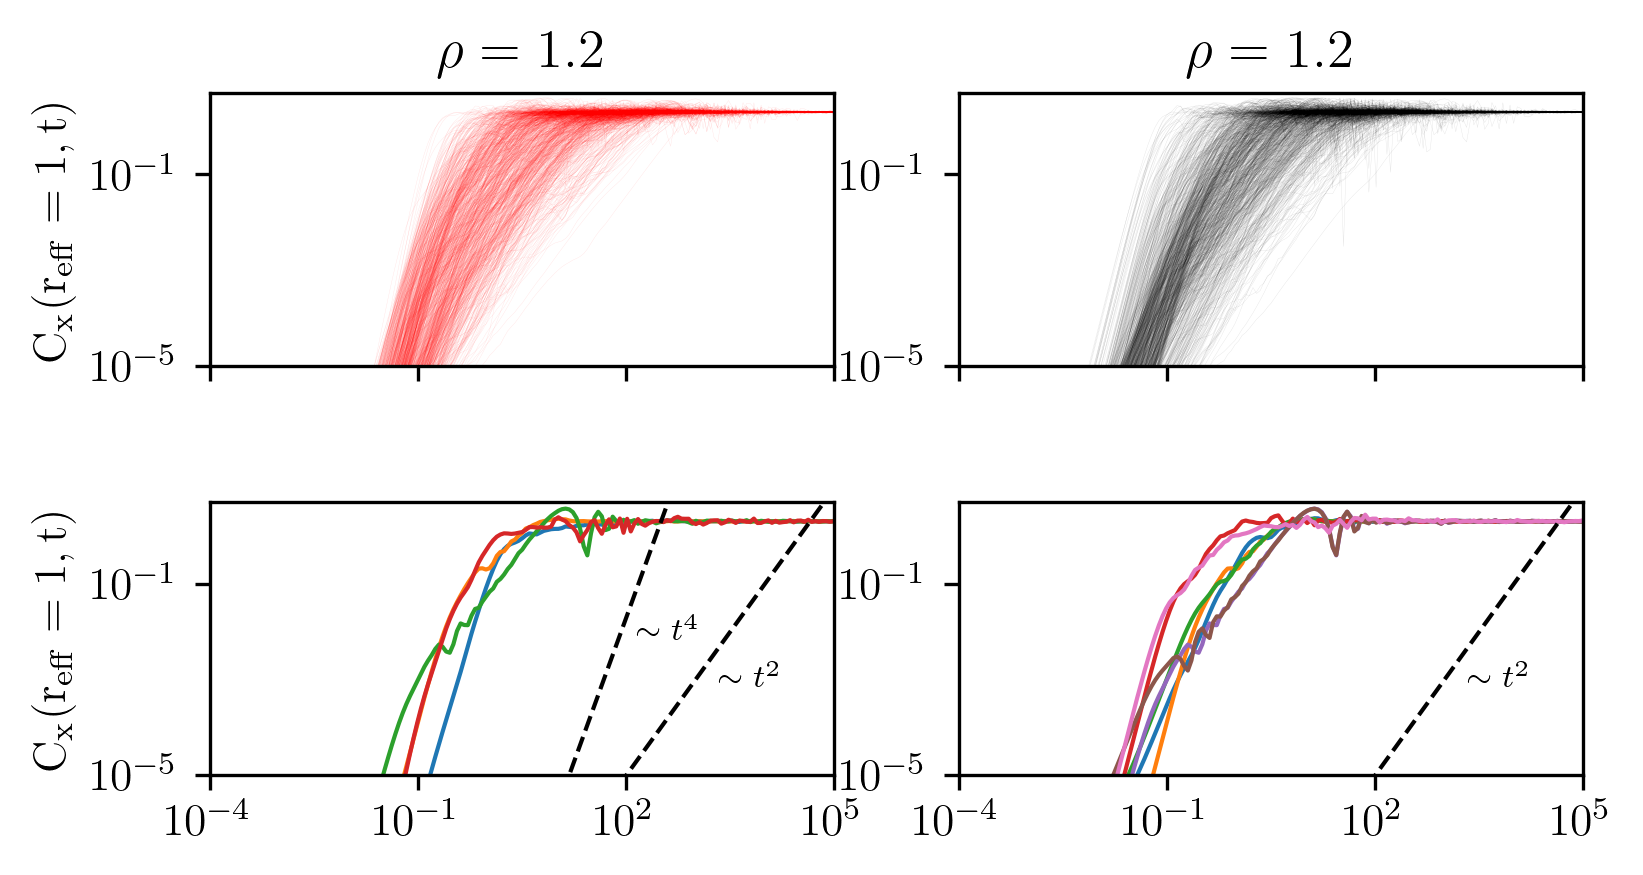

In [48]:
fig,axs = plt.subplots(2,2,figsize=set_size(aspect_ratio=0.5,subplots=(2,2)),dpi=300,sharex=True)

ds = 3

jeffs = get_jeff(distance_matrices[ds],spacings[ds])
jeffs_var = get_jeff_var(distance_matrices[ds],spacings[ds])

SHOTS = range(0,data[ds].shape[2])
SHOTS_pl = [1,10,54,248,268]

jeff = 3

axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")
for s in SHOTS:
    for j in range(0,N):
        if jeff == jeffs_var[j,s]:
            axs[0,0].plot(Jm[ds]*T,data[ds][:,j,s],lw=0.1,c="red",alpha=0.1)

axs[0,0].set_ylabel(r"$\mathrm{C_x(r_{eff}=1,t)}$")
axs[0,0].set_title(r"$\rho = {}$".format(rhos[ds]))
axs[0,0].set_xlim(1e-4,1e6)
axs[0,0].set_ylim(1e-5,5e0)


axs[0,1].set_xscale("log")
axs[0,1].set_yscale("log")
for s in SHOTS:
    for j in range(0,N):
        if jeff == jeffs[j,s]:
            axs[0,1].plot(Jm[ds]*T,data[ds][:,j,s],lw=0.1,c="black",alpha=0.1)

axs[0,1].set_title(r"$\rho = {}$".format(rhos[ds]))
axs[0,1].set_xlim(1e-4,1e6)
axs[0,1].set_ylim(1e-5,5e0)




axs[1,0].set_xscale("log")
axs[1,0].set_yscale("log")
for s in SHOTS_pl:
    for j in range(N//2,N):
        if jeff == jeffs_var[j,s]:
            axs[1,0].plot(Jm[ds]*T,data[ds][:,j,s],lw=1)

axs[1,0].plot(Jm[ds]*T,5e-3*T**4/1e12,c="black",ls="dashed",lw=1)
axs[1,0].plot(Jm[ds]*T,5e0*T**2/1e12,c="black",ls="dashed",lw=1)
axs[1,0].set_ylabel(r"$\mathrm{C_x(r_{eff}=1,t)}$")
axs[1,0].set_xlim(1e-4,1e5)
axs[1,0].set_ylim(1e-5,5e0)
axs[1,0].text(2*200,1e-2,r"$\sim t^4$",ha="center",va="center",fontsize="x-small")
axs[1,0].text(2*3000,1e-3,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")


axs[1,1].set_xscale("log")
axs[1,1].set_yscale("log")
for s in SHOTS_pl:
    for j in range(N//2,N):
        if jeff == jeffs[j,s]:
            axs[1,1].plot(Jm[ds]*T,data[ds][:,j,s],lw=1)

axs[1,1].plot(Jm[ds]*T,5e0*T**2/1e12,c="black",ls="dashed",lw=1)

axs[1,1].set_xlim(1e-4,1e5)
axs[1,1].set_ylim(1e-5,5e0)
axs[1,1].text(2*3000,1e-3,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")


# ds = 4

# jeffs = get_jeff(distance_matrices[ds],spacings[ds])
# jeffs_var = get_jeff_var(distance_matrices[ds],spacings[ds])
# jeff = 2

# axs[2,0].set_xscale("log")
# axs[2,0].set_yscale("log")
# for s in SHOTS:
#     for j in range(0,N):
#         if jeff == jeffs_var[j,s]:
#             axs[2,0].plot(Jm[ds]*T,data[ds][:,j,s],lw=0.1,c="red",alpha=0.1)

# axs[2,0].set_xlabel(r"Jt")
# axs[2,0].set_ylabel(r"$\mathrm{C_x(r_{eff}=2,t)}$")
# axs[2,0].set_title(r"$\rho = {}$".format(rhos[ds]))
# axs[2,0].set_xlim(1e-4,1e6)
# axs[2,0].set_ylim(1e-5,5e0)


# axs[2,1].set_xscale("log")
# axs[2,1].set_yscale("log")
# for s in SHOTS:
#     for j in range(0,N):
#         if jeff == jeffs[j,s]:
#             axs[2,1].plot(Jm[ds]*T,data[ds][:,j,s],lw=0.1,c="black",alpha=0.1)

# axs[2,1].set_title(r"$\rho = {}$".format(rhos[ds]))
# axs[2,1].set_xlim(1e-4,1e6)
# axs[2,1].set_ylim(1e-5,5e0)




# axs[3,0].set_xscale("log")
# axs[3,0].set_yscale("log")
# for s in SHOTS_pl:
#     for j in range(N//2,N):
#         if jeff == jeffs_var[j,s]:
#             axs[3,0].plot(Jm[ds]*T,data[ds][:,j,s],lw=1)

# axs[3,0].plot(Jm[ds]*T,1e20*T**6/1e12,c="black",ls="dashed",lw=1)
# axs[3,0].plot(Jm[ds]*T,1e-5*T**4/1e12,c="black",ls="dashed",lw=1)
# axs[3,0].plot(Jm[ds]*T,1e0*T**2/1e12,c="black",ls="dashed",lw=1)

# axs[3,0].set_xlabel(r"$\mathrm{J_mt}$")
# axs[3,0].set_ylabel(r"$\mathrm{C_x(r_{eff}=2,t)}$")
# axs[3,0].set_xlim(1e-4,1e5)
# axs[3,0].set_ylim(1e-5,5e0)
# axs[3,0].text(2e-3,1e-2,r"$\sim t^6$",ha="center",va="center",fontsize="x-small")
# axs[3,0].text(400,1e-2,r"$\sim t^4$",ha="center",va="center",fontsize="x-small")
# axs[3,0].text(3000,1e-3,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")


# axs[3,1].set_xscale("log")
# axs[3,1].set_yscale("log")
# for s in SHOTS_pl:
#     for j in range(N//2,N):
#         if jeff == jeffs[j,s]:
#             axs[3,1].plot(Jm[ds]*T,data[ds][:,j,s],lw=1)

# axs[3,1].plot(Jm[ds]*T,1e-5*T**4/1e12,c="black",ls="dashed",lw=1)
# axs[3,1].plot(Jm[ds]*T,1e0*T**2/1e12,c="black",ls="dashed",lw=1)

# axs[3,1].set_xlabel(r"$\mathrm{J_mt}$")
# axs[3,1].set_xlim(1e-4,1e5)
# axs[3,1].set_ylim(1e-5,5e0)
# axs[3,1].text(400,1e-2,r"$\sim t^4$",ha="center",va="center",fontsize="x-small")
# axs[3,1].text(3000,1e-3,r"$\sim t^2$",ha="center",va="center",fontsize="x-small")

plt.subplots_adjust(hspace=0.5)
plt.savefig(figurepath/"typical_pl_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [129]:
distance_matrices[3][0,1,:].max()

3.3711953740808136

(1e-12, 5.0)

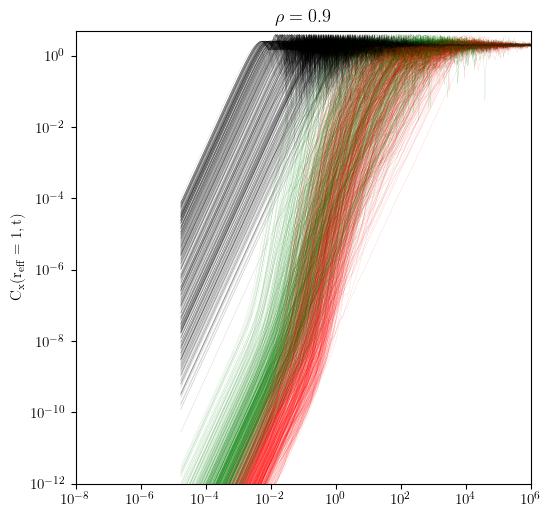

In [133]:
plt.xscale("log")
plt.yscale("log")
for s in SHOTS:
    plt.plot(Jm[ds]*T,data[ds][:,3,s],lw=0.1,c="green",alpha=0.5)
    plt.plot(Jm[ds]*T,data[ds][:,-5,s],lw=0.1,c="red",alpha=0.5)
    plt.plot(Jm[ds]*T,data[ds][:,0,s],lw=0.1,c="black",alpha=0.5)


plt.ylabel(r"$\mathrm{C_x(r_{eff}=1,t)}$")
plt.title(r"$\rho = {}$".format(rhos[ds]))
plt.xlim(1e-8,1e6)
plt.ylim(1e-12,5e0)

# Short Times

In [137]:
data[0].shape

(250, 13, 100)

In [141]:
np.count_nonzero(np.zeros(9,bool))

0

In [145]:
def filter_closest(arr,distance_matrix):
    good_r = np.zeros(arr.shape[2],bool)
    good_l = np.zeros(arr.shape[2],bool)
    for s in range(arr.shape[2]):
        if distance_matrix[0,1,s] < distance_matrix[1,2,s]:
            good_r[s] = True
        if distance_matrix[0,-1,s] < distance_matrix[-2,-1,s]:
            good_l[s] = True
    arr_r = np.zeros((arr.shape[0],arr.shape[1],np.count_nonzero(good_r)))
    arr_l = np.zeros((arr.shape[0],arr.shape[1],np.count_nonzero(good_l)))
    count_r = 0
    count_l = 0
    for s in range(arr.shape[2]):
        if good_r[s] == True:
            arr_r[:,:,count_r] = arr[:,:,s]
            count_r += 1 
        if good_l[s] == True:
            arr_l[:,:,count_l] = arr[:,:,s]
            count_l += 1
    return arr_r, arr_l

(1e-06, 10)

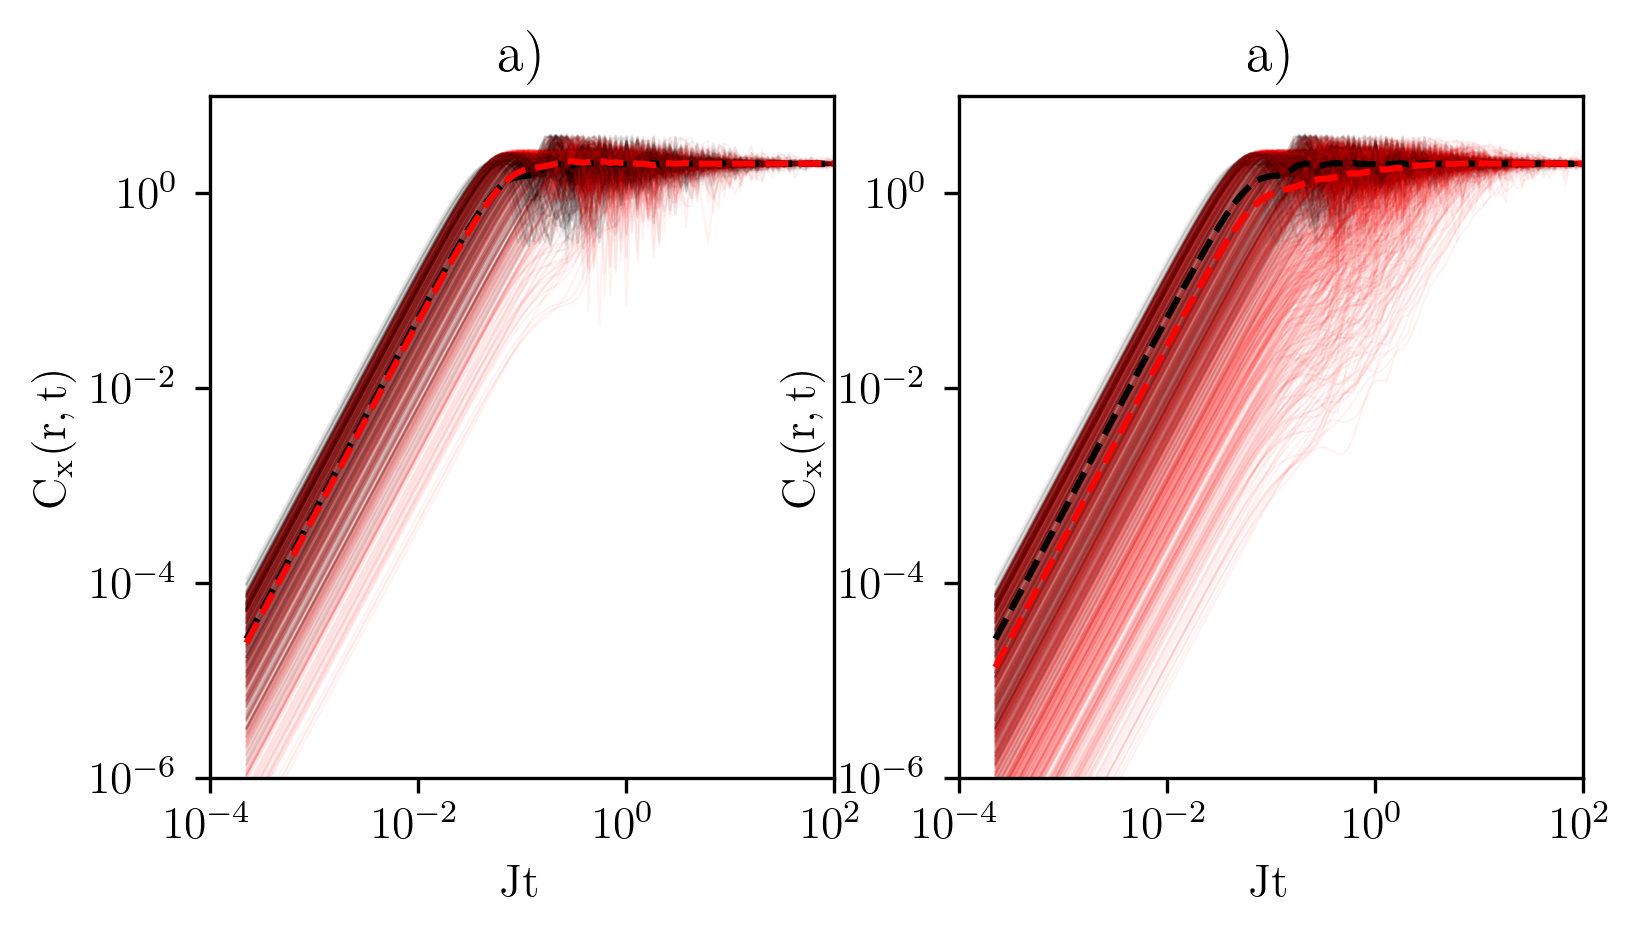

In [156]:
fig,axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi=300)

ds = 2

data_r, data_l = filter_closest(data[ds],distance_matrices[ds])

axs[0].set_yscale("log")
axs[0].set_xscale("log")
for s in range(0,data_r.shape[2]):
    axs[0].plot(Jm[ds]*T,data_r[:,0,s],c="black",alpha=0.05,lw=0.5)
    axs[0].plot(Jm[ds]*T,data_r[:,1,s],c="red",alpha=0.05,lw=0.5)
for s in range(0,data_l.shape[2]):
    axs[0].plot(Jm[ds]*T,data_l[:,0,s],c="black",alpha=0.05,lw=0.5)
    axs[0].plot(Jm[ds]*T,data_l[:,-1,s],c="red",alpha=0.05,lw=0.5)
    #axs[0].plot(Jm[ds]*T,data[ds][:,N//2+2,s],c="C1",alpha=0.1,lw=0.5)
    #axs[0].plot(Jm[ds]*T,data[ds][:,N//2-2,s],c="C1",alpha=0.1,lw=0.5)


axs[0].plot(Jm[ds]*T,res_m[ds][:,0],c="black",ls="dashed")
axs[0].plot(Jm[ds]*T,res_m[ds][:,1],c="red",ls="dashed")


axs[0].set_xlabel(r"Jt")
axs[0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[0].set_title("a)")
axs[0].set_xlim(1e-4,1e2)
axs[0].set_ylim(1e-6,10)

axs[1].set_yscale("log")
axs[1].set_xscale("log")
for s in range(0,data[ds].shape[2]):
    axs[1].plot(Jm[ds]*T,data[ds][:,0,s],c="black",alpha=0.05,lw=0.5)
    axs[1].plot(Jm[ds]*T,data[ds][:,1,s],c="red",alpha=0.05,lw=0.5)
    axs[1].plot(Jm[ds]*T,data[ds][:,-1,s],c="red",alpha=0.05,lw=0.5)
    #axs[0].plot(Jm[ds]*T,data[ds][:,N//2+2,s],c="C1",alpha=0.1,lw=0.5)
    #axs[0].plot(Jm[ds]*T,data[ds][:,N//2-2,s],c="C1",alpha=0.1,lw=0.5)


axs[1].plot(Jm[ds]*T,res_m_var[ds][:,0],c="black",ls="dashed")
axs[1].plot(Jm[ds]*T,res_m_var[ds][:,1],c="red",ls="dashed")


axs[1].set_xlabel(r"Jt")
axs[1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
axs[1].set_title("a)")
axs[1].set_xlim(1e-4,1e2)
axs[1].set_ylim(1e-6,10)

In [130]:
popt0 = []
perr0 = []
popt1 = []
perr1 = []
tfitmax = 30
tfitmin = 0
for ds in range(len(folders)):
    poptj, pcovj = curve_fit(model,T[0:tfitmax],res_m[ds][0:tfitmax,0])
    popt0.append(poptj)
    perr0.append(np.sqrt(np.diag(pcovj)))

    poptj, pcovj = curve_fit(model,T[0:tfitmax],res_m[ds][0:tfitmax,1])
    popt1.append(poptj)
    perr1.append(np.sqrt(np.diag(pcovj)))

In [131]:
popt0

[array([133.49190288,   1.9727055 ]),
 array([56.009303  ,  1.98807322]),
 array([25.55518117,  1.99210128]),
 array([15.0234576 ,  1.99329118]),
 array([9.45394144, 1.99370196]),
 array([4.15030774, 1.99335007])]

In [132]:
popt1

[array([72.71084999,  1.98416018]),
 array([45.01192777,  1.99055461]),
 array([23.38325067,  1.99299564]),
 array([13.32515587,  1.99347261]),
 array([8.67475602, 1.99417666]),
 array([3.35315064, 1.99335782])]

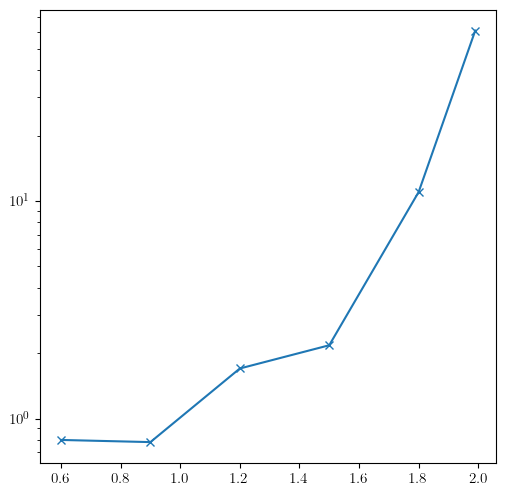

In [135]:
plt.plot(rhos,[popt0[ds][0]-popt1[ds][0] for ds in range(len(folders))],marker="x")
plt.yscale("log")